In [2]:
#!pip install torchmetrics -q
#!pip install datasets -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.9 MB/s eta 0:00:00


In [4]:
import torchmetrics
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from   sklearn.preprocessing   import LabelEncoder          # кодировка категорий
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [5]:
import datasets

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# New Section

In [6]:
from datasets import Dataset

In [7]:
# Читаем файл с компетенциями
df = pd.read_csv('/content/drive/MyDrive/simpsons_dataset.csv')

In [8]:
df.head(3)

,raw_character_text,spoken_words
0,Miss Hoover,"No, actually, it was a little of both. Sometim..."
1,Lisa Simpson,Where's Mr. Bergstrom?
2,Miss Hoover,I don't know. Although I'd sure like to talk t...


In [9]:
    def add_new_column(dataset):
        # Создаем новое поле number_dialog и инициализируем его значениями
        number_dialog = 0
        new_column = []
        # Итерируемся по датасету и пронумеровываем строки
        for index, row in dataset.iterrows():
            new_column.append(number_dialog)
            if pd.isnull(row['raw_character_text']):
                number_dialog += 1
        # Добавляем новое поле в датасет
        dataset['number_dialog'] = new_column
        return dataset

In [10]:
dataset_step0 = add_new_column(df)

In [11]:
dataset_step0.head(10)

,raw_character_text,spoken_words,number_dialog
0,Miss Hoover,"No, actually, it was a little of both. Sometim...",0
1,Lisa Simpson,Where's Mr. Bergstrom?,0
2,Miss Hoover,I don't know. Although I'd sure like to talk t...,0
3,Lisa Simpson,That life is worth living.,0
4,Edna Krabappel-Flanders,The polls will be open from now until the end ...,0
5,Martin Prince,I don't think there's anything left to say.,0
6,Edna Krabappel-Flanders,Bart?,0
7,Bart Simpson,Victory party under the slide!,0
8,NaN,NaN,0
9,Lisa Simpson,Mr. Bergstrom! Mr. Bergstrom!,1


In [12]:
    def process_dataset(dataset):
        dataset = dataset.dropna(subset=['spoken_words'])
        dataset = dataset.reset_index()
        new_rows = []

        character = None
        spoken_words = None

        for index, row in dataset.iterrows():
            if row['raw_character_text'] == character:
                spoken_words += " " + row['spoken_words']
                new_rows[-1]['spoken_words'] = spoken_words
                new_rows.pop()
                new_rows.append({'raw_character_text': character, 'spoken_words': spoken_words})
            else:
                character = row['raw_character_text']
                spoken_words = row['spoken_words']
                new_rows.append({'raw_character_text': character, 'spoken_words': spoken_words})

        new_dataset = pd.DataFrame(new_rows)
        return new_dataset

In [13]:
character_chatbot = "Homer Simpson"

In [14]:
    def transform_dataset(input_dataset, character_chatbot, label):
        if input_dataset['raw_character_text'][0] == character_chatbot:
            input_dataset = input_dataset.drop(0)
        output_data = []
        context_list = []
        prev_spoken_words = ""
        for index, row in input_dataset.iterrows():
            if row['raw_character_text'] == character_chatbot:
                A = row['spoken_words']
                Q = prev_spoken_words
                context_list.append(prev_spoken_words)
                if len(context_list) > 4:
                    context_list = context_list[-4:]
                Context = " ".join(context_list)
                output_data.append({'A': A, 'Q': Q, 'Context': Context, 'len_Context': len(context_list), 'label': label})
            prev_spoken_words = row['spoken_words']
        output_dataset = pd.DataFrame(output_data)
        return output_dataset

In [15]:
final_dataset = pd.DataFrame(columns=['A', 'Q', 'Context'])  # Создаем пустой датасет
        # Проходим по всем номерам из поля number_dialog

character_chatbot = "Homer Simpson"
for number in dataset_step0['number_dialog'].unique():
        # Отбираем строки, соответствующие текущему номеру
    selected_rows = dataset_step0[dataset_step0['number_dialog'] == number]
    if character_chatbot in selected_rows['raw_character_text'].values:
        dataset_step1 = process_dataset(selected_rows)
        if len(dataset_step1) > 1:
            dataset_step2 = transform_dataset(dataset_step1, character_chatbot = "Homer Simpson", label = 1.0)
            final_dataset = pd.concat([final_dataset, dataset_step2], ignore_index=True)
character_chatbot = "Lisa Simpson"
for number in dataset_step0['number_dialog'].unique():
        # Отбираем строки, соответствующие текущему номеру
    selected_rows = dataset_step0[dataset_step0['number_dialog'] == number]
    if character_chatbot in selected_rows['raw_character_text'].values:
        dataset_step1 = process_dataset(selected_rows)
        if len(dataset_step1) > 1:
            dataset_step2 = transform_dataset(dataset_step1, character_chatbot = "Lisa Simpson", label = 0.0)
            final_dataset = pd.concat([final_dataset, dataset_step2], ignore_index=True)

In [16]:
final_dataset = final_dataset[final_dataset['len_Context'] == 4.0]

In [17]:
final_dataset

,A,Q,Context,len_Context,label
3,Me?,I'm glad I'm not crying because I would hate f...,Mr. Bergstrom left today. He's gone. Forever. ...,4.0,1.0
4,I don't think you realize what you're saying.,"Yes, you! Baboon, baboon, baboon, baboon!",He's gone. Forever. I didn't think you'd under...,4.0,1.0
5,"Did you hear that, Marge? She called me a babo...","Whoa, somebody was bound to say it one day. I ...",I didn't think you'd understand. I'm glad I'm ...,4.0,1.0
6,"Go Away. Lisa, don't hold anything back. You c...","Homer, you are not allowed to have hurt feelin...",I'm glad I'm not crying because I would hate f...,4.0,1.0
7,Nuts. This isn't going well at all.,No!,"Yes, you! Baboon, baboon, baboon, baboon! Whoa...",4.0,1.0
...,...,...,...,...,...
27801,Can I paint my nails?,Yes.,Sure. Sure. No. Yes.,4.0,0.0
27802,Can we have wine?,No.,Sure. No. Yes. No.,4.0,0.0
27803,Can I have wine?,Yes.,No. Yes. No. Yes.,4.0,0.0
27804,Does Bart have to be there?,No.,Yes. No. Yes. No.,4.0,0.0


In [38]:
final_dataset.to_csv('/content/drive/MyDrive/Colab Notebooks/Homer/final_dataset_homer.csv')

In [19]:
homer_dataset ={"premise":[],
               "hypothesis" : [],
               "label": [] }

lim_context = 200

for index, row in final_dataset.iterrows():
    premise = [row["A"]+"[SEP]"+row["Context"][:lim_context]]
    hypothesis = [row["Q"]]
    labels =  [row["label"]]
    homer_dataset["premise"].extend(premise)
    homer_dataset["hypothesis"].extend(hypothesis)
    homer_dataset["label"].extend(labels)

In [20]:
dataset = datasets.Dataset.from_dict(homer_dataset)

In [21]:
dataset[0:5]

{'premise': ["Me?[SEP]Mr. Bergstrom left today. He's gone. Forever. I didn't think you'd understand. I'm glad I'm not crying because I would hate for you to think that what I'm about to say is based on emotion. But you, si",
  "I don't think you realize what you're saying.[SEP]He's gone. Forever. I didn't think you'd understand. I'm glad I'm not crying because I would hate for you to think that what I'm about to say is based on emotion. But you, sir, are a baboon! Yes, you!",
  "Did you hear that, Marge? She called me a baboon! The stupidest, ugliest, smelliest ape of them all![SEP]I didn't think you'd understand. I'm glad I'm not crying because I would hate for you to think that what I'm about to say is based on emotion. But you, sir, are a baboon! Yes, you! Baboon, baboon, bab",
  "Go Away. Lisa, don't hold anything back. You can tell me. Are you crying because you called Daddy a baboon?[SEP]I'm glad I'm not crying because I would hate for you to think that what I'm about to say is b

In [22]:
from typing import Callable, Iterable

import torch
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import AutoTokenizer, AutoModel
from transformers.optimization import get_linear_schedule_with_warmup
from scipy import stats
from sklearn.metrics.pairwise import cosine_similarity

In [23]:

class SnliDataset(Dataset):
    def __init__(self, premise_tokens: dict, hypothesis_tokens: dict, labels: Iterable[str]):
        self.premise_tokens = premise_tokens
        self.hypothesis_tokens = hypothesis_tokens
        self.labels = labels
        self._init_data()

    def _init_data(self) -> None:
        self.data = []
        for pt_ids, pt_am, ht_ids, ht_am, label in zip(
            self.premise_tokens["input_ids"], self.premise_tokens["attention_mask"],
            self.hypothesis_tokens["input_ids"], self.hypothesis_tokens["attention_mask"],
            self.labels
        ):
            data = {}
            data["premise_input_ids"] = torch.tensor(pt_ids, dtype=torch.long)
            data["premise_attention_mask"] = torch.tensor(pt_am, dtype=torch.long)
            data["hypothesis_input_ids"] = torch.tensor(ht_ids, dtype=torch.long)
            data["hypothesis_attention_mask"] = torch.tensor(ht_am, dtype=torch.long)
            data["label"] = torch.tensor(label, dtype=torch.long)
            self.data.append(data)

    def __getitem__(self, ix: int) -> dict[str, torch.tensor]:
        return self.data[ix]

    def __len__(self) -> int:
        return len(self.data)

In [24]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [25]:
MAX_LENGTH = 128

tokenized_premises = tokenizer([data["premise"] for data in dataset],
                               max_length=MAX_LENGTH, padding="max_length",
                               truncation=True, verbose=True)

tokenized_hypothesis = tokenizer([data["hypothesis"] for data in dataset],
                                 max_length=MAX_LENGTH, padding="max_length",
                                 truncation=True, verbose=True)

In [26]:
snli_dataset = SnliDataset(tokenized_premises,
                           tokenized_hypothesis,
                           (data["label"] for data in dataset))

In [27]:
train_ratio = 0.9
n_total = len(snli_dataset)
n_train = int(n_total * train_ratio)
n_val = n_total - n_train

train_dataset, val_dataset = random_split(snli_dataset, [n_train, n_val])

batch_size = 16  # mentioned in the paper
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [28]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [29]:
def mean_pool(token_embeds: torch.tensor, attention_mask: torch.tensor) -> torch.tensor:
    in_mask = attention_mask.unsqueeze(-1).expand(token_embeds.size()).float()
    pool = torch.sum(token_embeds * in_mask, 1) / torch.clamp(in_mask.sum(1), min=1e-9)
    return pool


def encode(input_texts: list[str], tokenizer: AutoTokenizer, model: AutoModel, device: str = "cpu"
) -> torch.tensor:

    model.eval()
    tokenized_texts = tokenizer(input_texts, max_length=128,
                                padding='max_length', truncation=True, return_tensors="pt")
    token_embeds = model(tokenized_texts["input_ids"].to(device),
                         tokenized_texts["attention_mask"].to(device)).last_hidden_state
    pooled_embeds = mean_pool(token_embeds, tokenized_texts["attention_mask"].to(device))
    return pooled_embeds


In [30]:
class Sbert(torch.nn.Module):
    def __init__(self, max_length: int = 128):
        super().__init__()
        self.max_length = max_length
        self.bert_model = AutoModel.from_pretrained('distilbert-base-uncased')
        self.bert_tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
        self.linear = torch.nn.Linear(self.bert_model.config.hidden_size * 3, 3)

    def forward(self, data: datasets.arrow_dataset.Dataset) -> torch.tensor:
        premise_input_ids = data["premise_input_ids"].to(device)
        premise_attention_mask = data["premise_attention_mask"].to(device)
        hypothesis_input_ids = data["hypothesis_input_ids"].to(device)
        hypothesis_attention_mask = data["hypothesis_attention_mask"].to(device)

        out_premise = self.bert_model(premise_input_ids, premise_attention_mask)
        out_hypothesis = self.bert_model(hypothesis_input_ids, hypothesis_attention_mask)
        premise_embeds = out_premise.last_hidden_state
        hypothesis_embeds = out_hypothesis.last_hidden_state

        pooled_premise_embeds = mean_pool(premise_embeds, premise_attention_mask)
        pooled_hypotheses_embeds = mean_pool(hypothesis_embeds, hypothesis_attention_mask)

        embeds =  torch.cat([pooled_premise_embeds, pooled_hypotheses_embeds,
                             torch.abs(pooled_premise_embeds - pooled_hypotheses_embeds)],
                            dim=-1)
        return self.linear(embeds)

In [31]:
bi_encoder = Sbert()
bi_encoder.to(device)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Sbert(
  (bert_model): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in_f

In [32]:
optimizer = torch.optim.AdamW(bi_encoder.parameters(), lr=2e-6)
total_steps = len(train_dataset) // batch_size
warmup_steps = int(0.1 * total_steps)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps,
                                            num_training_steps=total_steps - warmup_steps)

loss_fn = torch.nn.CrossEntropyLoss()

In [33]:
def get_train_step_fn(
    model: torch.nn.Module, optimizer: torch.optim.Optimizer,
    scheduler: torch.optim.lr_scheduler.LambdaLR, loss_fn: torch.nn.CrossEntropyLoss
) -> Callable[[torch.tensor, torch.tensor], float]:

    def train_step_fn(x: torch.tensor, y: torch.tensor) -> float:
        model.train()
        yhat = model(x)
        loss = loss_fn(yhat, y)
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        return loss.item()

    return train_step_fn


def get_val_step_fn(
    model: torch.nn.Module, loss_fn: torch.nn.CrossEntropyLoss
) -> Callable[[torch.tensor, torch.tensor], float]:

    def val_step_fn(x: torch.tensor, y: torch.tensor) -> float:
        model.eval()
        yhat = model(x)
        loss = loss_fn(yhat, y)
        return loss.item()

    return val_step_fn


def mini_batch(
    dataloader: DataLoader,
    step_fn: Callable[[torch.tensor, torch.tensor], float],
    is_training: bool = True
) -> tuple[np.array, list[float]]:

    mini_batch_losses = []

    if is_training:
        print("\nTraining ...")
    else:
        print("\nValidating ...")
    n_steps = len(dataloader)
    for i, data in enumerate(dataloader):
        loss = step_fn(data, data["label"].to(device))
        mini_batch_losses.append(loss)
        if i % (batch_size * 100) == 0:
            print(f"step {i:>5}/{n_steps}, loss = {loss: .3f}")

    return np.mean(mini_batch_losses), mini_batch_losses

In [34]:
%%time

n_epochs = 10  # mentioned in the paper

train_step_fn = get_train_step_fn(bi_encoder, optimizer, scheduler, loss_fn)
val_step_fn = get_val_step_fn(bi_encoder, loss_fn)

train_losses, train_mini_batch_losses = [], []
val_losses, val_mini_batch_losses = [], []

for epoch in range(1, n_epochs + 1):
    train_loss, _train_mini_batch_losses = mini_batch(train_dataloader, train_step_fn)
    train_mini_batch_losses += _train_mini_batch_losses
    train_losses.append(train_loss)

    with torch.no_grad():
        val_loss, _val_mini_batch_losses = mini_batch(val_dataloader, val_step_fn, is_training=False)
        val_mini_batch_losses += _val_mini_batch_losses
        val_losses.append(val_loss)


Training ...
step     0/368, loss =  1.102

Validating ...
step     0/41, loss =  0.507

Training ...
step     0/368, loss =  0.685

Validating ...
step     0/41, loss =  0.507

Training ...
step     0/368, loss =  0.473

Validating ...
step     0/41, loss =  0.507

Training ...
step     0/368, loss =  0.420

Validating ...
step     0/41, loss =  0.507

Training ...
step     0/368, loss =  0.766

Validating ...
step     0/41, loss =  0.507

Training ...
step     0/368, loss =  0.442

Validating ...
step     0/41, loss =  0.507

Training ...
step     0/368, loss =  0.489

Validating ...
step     0/41, loss =  0.507

Training ...
step     0/368, loss =  0.404

Validating ...
step     0/41, loss =  0.507

Training ...
step     0/368, loss =  0.420

Validating ...
step     0/41, loss =  0.507

Training ...
step     0/368, loss =  0.683

Validating ...
step     0/41, loss =  0.507
CPU times: user 20min 48s, sys: 23.4 s, total: 21min 12s
Wall time: 21min 37s


In [35]:
bi_encoder.bert_model.save_pretrained(f"/content/drive/MyDrive/Colab Notebooks/Homer/bi_encoder_homer")

In [36]:
window_size = 32

train_mb_running_loss = []
for i in range(len(train_mini_batch_losses)-window_size):
    train_mb_running_loss.append(np.mean(train_mini_batch_losses[i:i+window_size]))

val_mb_running_loss = []
for i in range(len(val_mini_batch_losses)-window_size):
    val_mb_running_loss.append(np.mean(val_mini_batch_losses[i:i+window_size]))

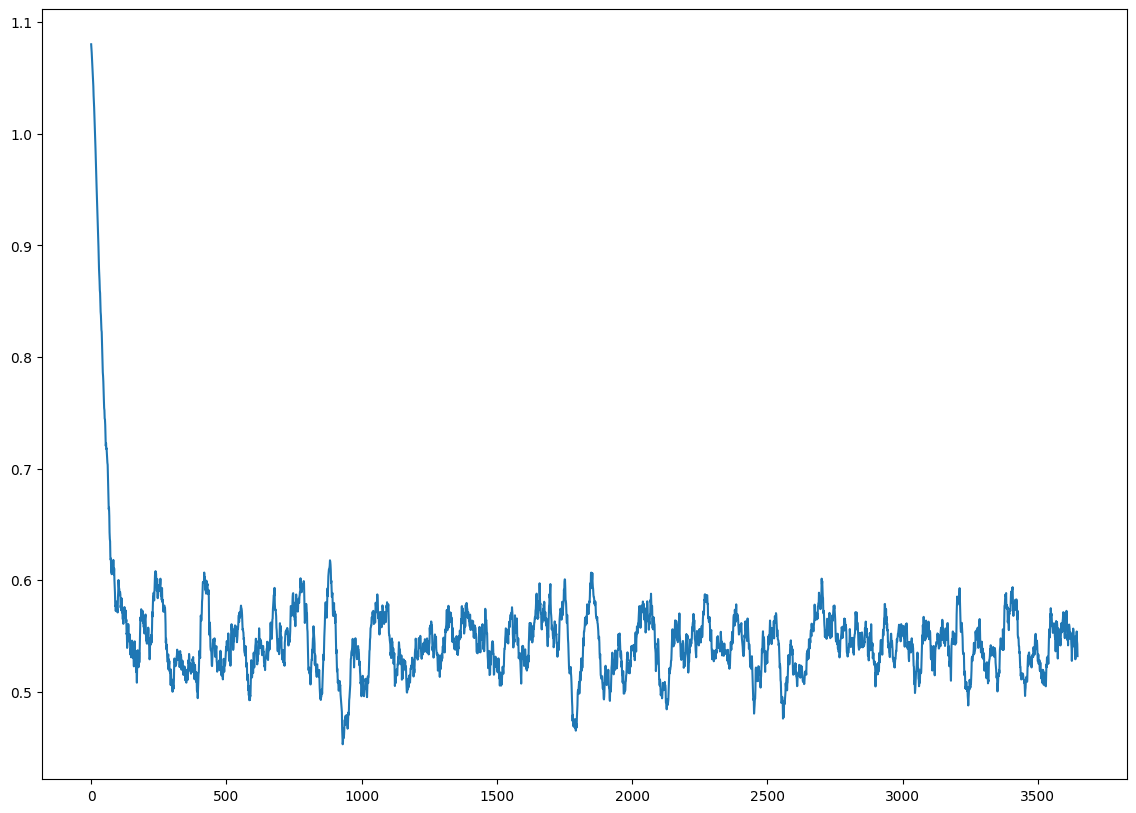

In [37]:
fix, ax = plt.subplots(figsize=(14, 10))
ax.plot(range(len(train_mb_running_loss)), train_mb_running_loss);